In [521]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from random import choice
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import roc_curve
from sklearn.decomposition import  PCA
from sklearn.preprocessing import StandardScaler


import warnings
warnings.filterwarnings("ignore")

In [522]:
df = pd.read_excel('Train_Dataset.xlsx',header=None)
df.head(5)
print(df.info())
df.rename(columns = {560:'Target'}, inplace=True)
print(df['Target'].unique())
df.describe()
df.isnull().any().any()
df.isnull().sum().sum()
new_df = df['Target']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Columns: 561 entries, 0 to 560
dtypes: float64(560), int64(1)
memory usage: 4.3 MB
None
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


## Creating random sample for Subject Train Target - Modified Version

In [523]:
def generate_auth_dataset(df, subj, ratio=3):
        subj_df = df.copy()
        subj_df.loc[(subj_df['Target'] != subj), 'Target'] = 0
        subj_df.loc[(subj_df['Target'] == subj), 'Target'] = 1
        gen_df = subj_df[subj_df['Target'] == 1]
        no_gen = gen_df.shape[0]
        imp_df = subj_df[subj_df['Target'] == 0].sample(n = no_gen * ratio)
        auth_df = pd.concat([gen_df, imp_df])
        return auth_df

In [524]:
df1 = generate_auth_dataset(df,1)

In [525]:
df1['Target'].value_counts()

0    132
1     44
Name: Target, dtype: int64

# Subject 1 Preparation For Train Dataset

## Applying StandardScaler to Dataset

In [526]:
scaler = StandardScaler()
X_Feat, y_train = df1.iloc[:, :-1].values, df1.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data = scaler.transform(X_Feat)

## Feature Reductionality -  PCA 

In [527]:
pca = PCA(n_components=30)
pca.fit(scaled_data)
x_pca = pca.transform(scaled_data)
x_pca.shape

(176, 30)

# Loading Dataset for Subject 1 Testing

In [528]:
df_test = pd.read_excel('Test_Dataset.xlsx',header=None)
df_test.rename(columns = {560:'Target'}, inplace=True)


In [529]:
df1_test = generate_auth_dataset(df_test, 1, ratio=3)

In [530]:
df1_test['Target'].unique()

array([1, 0], dtype=int64)

In [531]:
df1_test['Target'].value_counts()

0    72
1    24
Name: Target, dtype: int64

## Applying StandardScaler to Dataset

In [532]:
scaler = StandardScaler()
X_Feat_test, y_test = df1_test.iloc[:, :-1].values, df1_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test = scaler.transform(X_Feat_test)

# Feature Reductionality -  PCA 

In [533]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test)
x_pca_test = pca.transform(scaled_data_test)
x_pca_test.shape

(96, 30)

# Machine Learning Application

## Assigning Train and test Labels to Loaded Dataset

In [534]:
X_test = x_pca_test
X_train = x_pca

In [535]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[72  0]
 [24  0]]


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        72
           1       0.00      0.00      0.00        24

    accuracy                           0.75        96
   macro avg       0.38      0.50      0.43        96
weighted avg       0.56      0.75      0.64        96



In [536]:
score_test1 = accuracy_score(y_test,predictions)
score_test1

0.75

In [537]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
# SVC best estimator
# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)
svc = grid_svc.best_estimator_

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
#print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

In [538]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

svc = grid_svc.best_estimator_

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

In [539]:
from sklearn.metrics import roc_auc_score

print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))

Support Vector Classifier:  0.8610537190082644


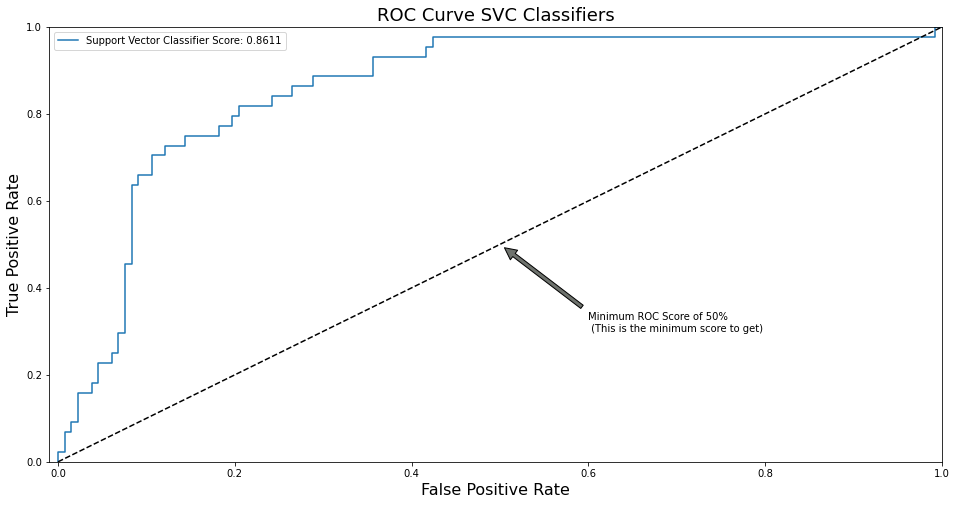

In [540]:
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)

def graph_roc_curve_multiple(svc_fpr, svc_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve SVC Classifiers', fontsize=18)
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(svc_fpr, svc_tpr)
plt.show()

# Subject 2

In [541]:
df2 = generate_auth_dataset(df,2, ratio=3)
df2_test = generate_auth_dataset(df_test,2, ratio=3)

In [542]:
scaler = StandardScaler()
X_Feat, y_train = df2.iloc[:, :-1].values, df2.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data2 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df2_test.iloc[:, :-1].values, df2_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test2 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data)
x_pca2 = pca.transform(scaled_data2)
x_pca2.shape


(192, 30)

In [543]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test)
x_pca_test2 = pca.transform(scaled_data_test2)
x_pca_test2.shape

(96, 30)

In [544]:
X_test = x_pca_test2
X_train = x_pca2

In [545]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test2 = accuracy_score(y_test,predictions)

[[70  2]
 [24  0]]


              precision    recall  f1-score   support

           0       0.74      0.97      0.84        72
           1       0.00      0.00      0.00        24

    accuracy                           0.73        96
   macro avg       0.37      0.49      0.42        96
weighted avg       0.56      0.73      0.63        96



## Subject 3

In [546]:
df3 = generate_auth_dataset(df,3, ratio=3)
df3_test = generate_auth_dataset(df_test,3, ratio=3)

In [547]:
scaler = StandardScaler()
X_Feat, y_train = df3.iloc[:, :-1].values, df3.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data3 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df3_test.iloc[:, :-1].values, df3_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test3 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data)
x_pca3 = pca.transform(scaled_data3)
x_pca3.shape


(188, 30)

In [548]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test)
x_pca_test3 = pca.transform(scaled_data_test3)
x_pca_test3.shape

(96, 30)

In [549]:
X_test = x_pca_test3
X_train = x_pca3

In [550]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test3 = accuracy_score(y_test,predictions)

[[52 20]
 [24  0]]


              precision    recall  f1-score   support

           0       0.68      0.72      0.70        72
           1       0.00      0.00      0.00        24

    accuracy                           0.54        96
   macro avg       0.34      0.36      0.35        96
weighted avg       0.51      0.54      0.53        96



In [551]:
df4 = generate_auth_dataset(df,4, ratio=3)
df4_test = generate_auth_dataset(df_test,4, ratio=3)

In [552]:
scaler = StandardScaler()
X_Feat, y_train = df4.iloc[:, :-1].values, df4.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data4 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df4_test.iloc[:, :-1].values, df4_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test4 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data4)
x_pca4 = pca.transform(scaled_data4)
x_pca4.shape


(176, 30)

In [553]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test4)
x_pca_test4 = pca.transform(scaled_data_test4)
x_pca_test4.shape

(56, 30)

In [554]:
X_test = x_pca_test4
X_train = x_pca4

In [555]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test4 = accuracy_score(y_test,predictions)

[[37  5]
 [14  0]]


              precision    recall  f1-score   support

           0       0.73      0.88      0.80        42
           1       0.00      0.00      0.00        14

    accuracy                           0.66        56
   macro avg       0.36      0.44      0.40        56
weighted avg       0.54      0.66      0.60        56



In [556]:
df5 = generate_auth_dataset(df,5, ratio=3)
df5_test = generate_auth_dataset(df_test,5, ratio=3)

In [557]:
scaler = StandardScaler()
X_Feat, y_train = df5.iloc[:, :-1].values, df5.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data5 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df5_test.iloc[:, :-1].values, df5_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test5 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data5)
x_pca5 = pca.transform(scaled_data5)
x_pca5.shape

(192, 30)

In [558]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test5)
x_pca_test5 = pca.transform(scaled_data_test5)
x_pca_test5.shape

(96, 30)

In [559]:
X_test = x_pca_test5
X_train = x_pca5

In [560]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test5 = accuracy_score(y_test,predictions)

[[57 15]
 [24  0]]


              precision    recall  f1-score   support

           0       0.70      0.79      0.75        72
           1       0.00      0.00      0.00        24

    accuracy                           0.59        96
   macro avg       0.35      0.40      0.37        96
weighted avg       0.53      0.59      0.56        96



In [561]:
df6 = generate_auth_dataset(df,6, ratio=3)
df6_test = generate_auth_dataset(df_test,6, ratio=3)

In [562]:
scaler = StandardScaler()
X_Feat, y_train = df6.iloc[:, :-1].values, df6.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data6 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df6_test.iloc[:, :-1].values, df6_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test6 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data6)
x_pca6 = pca.transform(scaled_data6)
x_pca6.shape

(192, 30)

In [563]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test6)
x_pca_test6 = pca.transform(scaled_data_test6)
x_pca_test6.shape

(96, 30)

In [564]:
X_test = x_pca_test6
X_train = x_pca6

In [565]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test6 = accuracy_score(y_test,predictions)

[[71  1]
 [22  2]]


              precision    recall  f1-score   support

           0       0.76      0.99      0.86        72
           1       0.67      0.08      0.15        24

    accuracy                           0.76        96
   macro avg       0.72      0.53      0.50        96
weighted avg       0.74      0.76      0.68        96



In [566]:
df7 = generate_auth_dataset(df,7, ratio=3)
df7_test = generate_auth_dataset(df_test,7, ratio=3)

In [567]:
scaler = StandardScaler()
X_Feat, y_train = df7.iloc[:, :-1].values, df7.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data7 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df7_test.iloc[:, :-1].values, df7_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test7 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data7)
x_pca7 = pca.transform(scaled_data7)
x_pca7.shape

(192, 30)

In [568]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test7)
x_pca_test7 = pca.transform(scaled_data_test7)
x_pca_test7.shape

(96, 30)

In [569]:
X_test = x_pca_test7
X_train = x_pca7

In [570]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test7 = accuracy_score(y_test,predictions)

[[72  0]
 [23  1]]


              precision    recall  f1-score   support

           0       0.76      1.00      0.86        72
           1       1.00      0.04      0.08        24

    accuracy                           0.76        96
   macro avg       0.88      0.52      0.47        96
weighted avg       0.82      0.76      0.67        96



In [571]:
df8 = generate_auth_dataset(df,8, ratio=3)
df8_test = generate_auth_dataset(df_test,8, ratio=3)

In [572]:
scaler = StandardScaler()
X_Feat, y_train = df8.iloc[:, :-1].values, df8.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data8 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df8_test.iloc[:, :-1].values, df8_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test8 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data8)
x_pca8 = pca.transform(scaled_data8)
x_pca8.shape

(192, 30)

In [573]:
pca = PCA(n_components=30)
pca.fit(scaled_data_test8)
x_pca_test8 = pca.transform(scaled_data_test8)
x_pca_test8.shape

(96, 30)

In [574]:
X_test = x_pca_test8
X_train = x_pca8

In [575]:
model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test8 = accuracy_score(y_test,predictions)

[[58 14]
 [22  2]]


              precision    recall  f1-score   support

           0       0.72      0.81      0.76        72
           1       0.12      0.08      0.10        24

    accuracy                           0.62        96
   macro avg       0.42      0.44      0.43        96
weighted avg       0.57      0.62      0.60        96



In [576]:
df9 = generate_auth_dataset(df,9, ratio=3)
df9_test = generate_auth_dataset(df_test,9, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df9.iloc[:, :-1].values, df9.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data9 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df9_test.iloc[:, :-1].values, df9_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test9 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data9)
x_pca9 = pca.transform(scaled_data9)

pca = PCA(n_components=30)
pca.fit(scaled_data_test9)
x_pca_test9 = pca.transform(scaled_data_test9)

X_test = x_pca_test9
X_train = x_pca9

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test9 = accuracy_score(y_test,predictions)

[[66  6]
 [12 12]]


              precision    recall  f1-score   support

           0       0.85      0.92      0.88        72
           1       0.67      0.50      0.57        24

    accuracy                           0.81        96
   macro avg       0.76      0.71      0.73        96
weighted avg       0.80      0.81      0.80        96



In [577]:
df10 = generate_auth_dataset(df,10, ratio=3)
df10_test = generate_auth_dataset(df_test,10, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df10.iloc[:, :-1].values, df10.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data10 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df10_test.iloc[:, :-1].values, df10_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test10 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data10)
x_pca10 = pca.transform(scaled_data10)

pca = PCA(n_components=30)
pca.fit(scaled_data_test10)
x_pca_test10 = pca.transform(scaled_data_test10)

X_test = x_pca_test10
X_train = x_pca10

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test10 = accuracy_score(y_test,predictions)

[[63  3]
 [21  1]]


              precision    recall  f1-score   support

           0       0.75      0.95      0.84        66
           1       0.25      0.05      0.08        22

    accuracy                           0.73        88
   macro avg       0.50      0.50      0.46        88
weighted avg       0.62      0.73      0.65        88



In [578]:
df11 = generate_auth_dataset(df,11, ratio=3)
df11_test = generate_auth_dataset(df_test,11, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df11.iloc[:, :-1].values, df11.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data11 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df11_test.iloc[:, :-1].values, df11_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test11 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data11)
x_pca11 = pca.transform(scaled_data11)

pca = PCA(n_components=30)
pca.fit(scaled_data_test11)
x_pca_test11 = pca.transform(scaled_data_test11)

X_test = x_pca_test11
X_train = x_pca11

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test11 = accuracy_score(y_test,predictions)

[[66  6]
 [16  8]]


              precision    recall  f1-score   support

           0       0.80      0.92      0.86        72
           1       0.57      0.33      0.42        24

    accuracy                           0.77        96
   macro avg       0.69      0.62      0.64        96
weighted avg       0.75      0.77      0.75        96



In [579]:
df12 = generate_auth_dataset(df,12, ratio=3)
df12_test = generate_auth_dataset(df_test,12, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df12.iloc[:, :-1].values, df12.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data12 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df12_test.iloc[:, :-1].values, df12_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test12 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data12)
x_pca12 = pca.transform(scaled_data12)

pca = PCA(n_components=30)
pca.fit(scaled_data_test12)
x_pca_test12 = pca.transform(scaled_data_test12)

X_test = x_pca_test12
X_train = x_pca12

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test12 = accuracy_score(y_test,predictions)

[[71  1]
 [18  6]]


              precision    recall  f1-score   support

           0       0.80      0.99      0.88        72
           1       0.86      0.25      0.39        24

    accuracy                           0.80        96
   macro avg       0.83      0.62      0.63        96
weighted avg       0.81      0.80      0.76        96



In [580]:
df13 = generate_auth_dataset(df,13, ratio=3)
df13_test = generate_auth_dataset(df_test,13, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df13.iloc[:, :-1].values, df13.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data13 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df13_test.iloc[:, :-1].values, df13_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test13 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data13)
x_pca13 = pca.transform(scaled_data13)

pca = PCA(n_components=30)
pca.fit(scaled_data_test13)
x_pca_test13 = pca.transform(scaled_data_test13)

X_test = x_pca_test13
X_train = x_pca13

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test13 = accuracy_score(y_test,predictions)

[[68  4]
 [22  2]]


              precision    recall  f1-score   support

           0       0.76      0.94      0.84        72
           1       0.33      0.08      0.13        24

    accuracy                           0.73        96
   macro avg       0.54      0.51      0.49        96
weighted avg       0.65      0.73      0.66        96



In [581]:
df14 = generate_auth_dataset(df,14, ratio=3)
df14_test = generate_auth_dataset(df_test,14, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df14.iloc[:, :-1].values, df14.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data14 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df14_test.iloc[:, :-1].values, df14_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test14 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data14)
x_pca14 = pca.transform(scaled_data14)

pca = PCA(n_components=30)
pca.fit(scaled_data_test14)
x_pca_test14 = pca.transform(scaled_data_test14)

X_test = x_pca_test14
X_train = x_pca14

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test14 = accuracy_score(y_test,predictions)

[[70  2]
 [24  0]]


              precision    recall  f1-score   support

           0       0.74      0.97      0.84        72
           1       0.00      0.00      0.00        24

    accuracy                           0.73        96
   macro avg       0.37      0.49      0.42        96
weighted avg       0.56      0.73      0.63        96



In [582]:
df15 = generate_auth_dataset(df,15, ratio=3)
df15_test = generate_auth_dataset(df_test,15, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df15.iloc[:, :-1].values, df15.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data15 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df15_test.iloc[:, :-1].values, df15_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test15 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data15)
x_pca15 = pca.transform(scaled_data15)

pca = PCA(n_components=30)
pca.fit(scaled_data_test15)
x_pca_test15 = pca.transform(scaled_data_test15)

X_test = x_pca_test15
X_train = x_pca15

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test15 = accuracy_score(y_test,predictions)

[[67  5]
 [17  7]]


              precision    recall  f1-score   support

           0       0.80      0.93      0.86        72
           1       0.58      0.29      0.39        24

    accuracy                           0.77        96
   macro avg       0.69      0.61      0.62        96
weighted avg       0.74      0.77      0.74        96



In [583]:
df16 = generate_auth_dataset(df,16, ratio=3)
df16_test = generate_auth_dataset(df_test,16, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df16.iloc[:, :-1].values, df16.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data16 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df16_test.iloc[:, :-1].values, df16_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test16 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data16)
x_pca16 = pca.transform(scaled_data16)

pca = PCA(n_components=30)
pca.fit(scaled_data_test16)
x_pca_test16 = pca.transform(scaled_data_test16)

X_test = x_pca_test16
X_train = x_pca16

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test16 = accuracy_score(y_test,predictions)

[[66  6]
 [19  5]]


              precision    recall  f1-score   support

           0       0.78      0.92      0.84        72
           1       0.45      0.21      0.29        24

    accuracy                           0.74        96
   macro avg       0.62      0.56      0.56        96
weighted avg       0.70      0.74      0.70        96



In [584]:
df17 = generate_auth_dataset(df,17, ratio=3)
df17_test = generate_auth_dataset(df_test,17, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df17.iloc[:, :-1].values, df17.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data17 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df17_test.iloc[:, :-1].values, df17_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test17 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data17)
x_pca17 = pca.transform(scaled_data17)

pca = PCA(n_components=30)
pca.fit(scaled_data_test17)
x_pca_test17 = pca.transform(scaled_data_test17)

X_test = x_pca_test17
X_train = x_pca17

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test17 = accuracy_score(y_test,predictions)

[[55 17]
 [24  0]]


              precision    recall  f1-score   support

           0       0.70      0.76      0.73        72
           1       0.00      0.00      0.00        24

    accuracy                           0.57        96
   macro avg       0.35      0.38      0.36        96
weighted avg       0.52      0.57      0.55        96



In [585]:
df18 = generate_auth_dataset(df,18, ratio=3)
df18_test = generate_auth_dataset(df_test,18, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df18.iloc[:, :-1].values, df18.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data18 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df18_test.iloc[:, :-1].values, df18_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test18 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data18)
x_pca18 = pca.transform(scaled_data18)

pca = PCA(n_components=30)
pca.fit(scaled_data_test18)
x_pca_test18 = pca.transform(scaled_data_test18)

X_test = x_pca_test18
X_train = x_pca18

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test18 = accuracy_score(y_test,predictions)

[[52 20]
 [24  0]]


              precision    recall  f1-score   support

           0       0.68      0.72      0.70        72
           1       0.00      0.00      0.00        24

    accuracy                           0.54        96
   macro avg       0.34      0.36      0.35        96
weighted avg       0.51      0.54      0.53        96



In [586]:
df19 = generate_auth_dataset(df,19, ratio=3)
df19_test = generate_auth_dataset(df_test,19, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df19.iloc[:, :-1].values, df19.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data19 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df19_test.iloc[:, :-1].values, df19_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test19 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data19)
x_pca19 = pca.transform(scaled_data19)

pca = PCA(n_components=30)
pca.fit(scaled_data_test19)
x_pca_test19 = pca.transform(scaled_data_test19)

X_test = x_pca_test19
X_train = x_pca19

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test19 = accuracy_score(y_test,predictions)

[[67  5]
 [ 0 24]]


              precision    recall  f1-score   support

           0       1.00      0.93      0.96        72
           1       0.83      1.00      0.91        24

    accuracy                           0.95        96
   macro avg       0.91      0.97      0.93        96
weighted avg       0.96      0.95      0.95        96



In [587]:
df20 = generate_auth_dataset(df,20, ratio=3)
df20_test = generate_auth_dataset(df_test,20, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df20.iloc[:, :-1].values, df20.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data20 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df20_test.iloc[:, :-1].values, df20_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test20 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data20)
x_pca20 = pca.transform(scaled_data20)

pca = PCA(n_components=30)
pca.fit(scaled_data_test20)
x_pca_test20 = pca.transform(scaled_data_test20)

X_test = x_pca_test20
X_train = x_pca20

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test20 = accuracy_score(y_test,predictions)

[[55  2]
 [19  0]]


              precision    recall  f1-score   support

           0       0.74      0.96      0.84        57
           1       0.00      0.00      0.00        19

    accuracy                           0.72        76
   macro avg       0.37      0.48      0.42        76
weighted avg       0.56      0.72      0.63        76



In [588]:
df21 = generate_auth_dataset(df,21, ratio=3)
df21_test = generate_auth_dataset(df_test,21, ratio=3)

scaler = StandardScaler()
X_Feat, y_train = df21.iloc[:, :-1].values, df21.iloc[:, -1].values
scaler.fit(X_Feat)
scaled_data21 = scaler.transform(X_Feat)

scaler = StandardScaler()
X_Feat_test, y_test = df21_test.iloc[:, :-1].values, df21_test.iloc[:, -1].values
scaler.fit(X_Feat_test)
scaled_data_test21 = scaler.transform(X_Feat_test)

pca = PCA(n_components=30)
pca.fit(scaled_data21)
x_pca21 = pca.transform(scaled_data21)

pca = PCA(n_components=30)
pca.fit(scaled_data_test21)
x_pca_test21 = pca.transform(scaled_data_test21)

X_test = x_pca_test21
X_train = x_pca21

model = SVC()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score

print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

score_test21 = accuracy_score(y_test,predictions)

[[72  0]
 [24  0]]


              precision    recall  f1-score   support

           0       0.75      1.00      0.86        72
           1       0.00      0.00      0.00        24

    accuracy                           0.75        96
   macro avg       0.38      0.50      0.43        96
weighted avg       0.56      0.75      0.64        96



In [590]:
data = {'Score Name':['Subject 1', 'Subject 2', 'Subject 3', 'Subject 4', 'Subject 5', 'Subject 6','Subject 7', 'Subject 8', 'Subject 9', 'Subject 10', 'Subject 11', 'Subject 12', 'Subject 13', 'Subject 14', 'Subject 15', 'Subject 16', 'Subject 17', 'Subject 18', 'Subject 19', 'Subject 20', 'Subject 21'],
        'Scores':[score_test1*100, score_test2*100, score_test3*100, score_test4*100, score_test5*100, score_test6*100, score_test7*100, score_test8*100, score_test9*100, score_test10*100, score_test11*100, score_test12*100, score_test13*100, score_test14*100, score_test15*100, score_test16*100, score_test17*100, score_test18*100, score_test19*100, score_test20*100, score_test21*100]}

df_score = pd.DataFrame(data)
df_score        

,Score Name,Scores
0,Subject 1,75.000000
1,Subject 2,72.916667
2,Subject 3,54.166667
3,Subject 4,66.071429
4,Subject 5,59.375000
5,Subject 6,76.041667
6,Subject 7,76.041667
7,Subject 8,62.500000
8,Subject 9,81.250000
9,Subject 10,72.727273
